## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


os.environ["CUDA_DEVICES_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization

def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128], 
              drp_ratio=0.2, 
              l1_ratio=1e-4, 
              l2_ratio=1e-4, 
              use_bn=True):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   name=f"hidden_layer{i+1}",
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            if use_bn:
                x = BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
            x = keras.layers.Dropout(rate=drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name=f"hidden_layer{i+1}", 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
            x = keras.layers.Dropout(rate=drp_ratio)(x)
            
        out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
        model = keras.models.Model(inputs=[input_layer], outputs=[out])
        
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = 0.95

L1_RATIO = 1e-2
L2_RATIO = [1e-2, 1e-4]
DRP_RATIO = [0.1, 0.25, 0.5]
USE_BN = [True, False]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    keras.backend.clear_session()
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f, l1_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio, L1_RATIO))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, 
              y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0720 20:53:04.632411 13176 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0720 20:53:04.633410 13176 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 20:53:04.649421 13176 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 20:53:04.650405 13176 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 20:53:04.652404 13176 depr

Numbers of exp: 0, with bn: True, drp_ratio: 0.10, l2_ratio: 0.01, l1_ratio: 0.01


W0720 20:53:05.059274 13176 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

W0720 20:53:05.318192 13176 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 6s 117us/step - loss: 6.5677 - acc: 0.3656 - val_loss: 3.3404 - val_acc: 0.1860
Epoch 2/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.5478 - acc: 0.3972 - val_loss: 2.9567 - val_acc: 0.1614
Epoch 3/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.3089 - acc: 0.4045 - val_loss: 2.7588 - val_acc: 0.2253
Epoch 4/30
50000/50000 [==============================] - 4s 70us/step - loss: 2.2435 - acc: 0.4074 - val_loss: 2.6260 - val_acc: 0.2356
Epoch 5/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.2020 - acc: 0.4164 - val_loss: 2.7401 - val_acc: 0.1784
Epoch 6/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.1863 - acc: 0.4202 - val_loss: 2.6900 - val_acc: 0.2492
Epoch 7/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.1593 - acc: 0.4251 - val_loss: 2.9794 - val_ac

50000/50000 [==============================] - 4s 73us/step - loss: 1.8931 - acc: 0.5193 - val_loss: 2.2060 - val_acc: 0.3993
Epoch 14/30
50000/50000 [==============================] - 4s 73us/step - loss: 1.8654 - acc: 0.5247 - val_loss: 2.2800 - val_acc: 0.3604
Epoch 15/30
50000/50000 [==============================] - 4s 73us/step - loss: 1.8572 - acc: 0.5245 - val_loss: 2.2955 - val_acc: 0.3496
Epoch 16/30
50000/50000 [==============================] - 4s 73us/step - loss: 1.8346 - acc: 0.5277 - val_loss: 2.3407 - val_acc: 0.3421
Epoch 17/30
50000/50000 [==============================] - 4s 76us/step - loss: 1.8238 - acc: 0.5308 - val_loss: 2.3276 - val_acc: 0.3359
Epoch 18/30
50000/50000 [==============================] - 4s 73us/step - loss: 1.8023 - acc: 0.5358 - val_loss: 2.6059 - val_acc: 0.3417
Epoch 19/30
50000/50000 [==============================] - 4s 73us/step - loss: 1.7883 - acc: 0.5361 - val_loss: 2.2911 - val_acc: 0.3547
Epoch 20/30
50000/50000 [=====================

50000/50000 [==============================] - 4s 71us/step - loss: 2.2032 - acc: 0.4037 - val_loss: 2.5300 - val_acc: 0.2605
Epoch 26/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.1913 - acc: 0.4074 - val_loss: 2.4149 - val_acc: 0.3014
Epoch 27/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.1867 - acc: 0.4049 - val_loss: 2.5123 - val_acc: 0.2664
Epoch 28/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.1718 - acc: 0.4045 - val_loss: 2.5026 - val_acc: 0.2512
Epoch 29/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.1656 - acc: 0.4095 - val_loss: 2.5049 - val_acc: 0.2704
Epoch 30/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.1570 - acc: 0.4069 - val_loss: 2.3973 - val_acc: 0.3252
Numbers of exp: 3, with bn: True, drp_ratio: 0.25, l2_ratio: 0.00, l1_ratio: 0.01
_________________________________________________________________
Layer (type)                 Output 

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 5s 95us/step - loss: 7.8520 - acc: 0.2495 - val_loss: 3.9094 - val_acc: 0.1581
Epoch 2/30
50000/50000 [==============================] - 4s 71us/step - loss: 3.0309 - acc: 0.3145 - val_loss: 2.8780 - val_acc: 0.2848
Epoch 3/30
50000/50000 [==============================] - 4s 70us/step - loss: 2.6185 - acc: 0.3338 - val_loss: 2.7337 - val_acc: 0.2491
Epoch 4/30
50000/50000 [==============================] - 4s 70us/step - loss: 2.5473 - acc: 0.3367 - val_loss: 2.9522 - val_acc: 0.1880
Epoch 5/30
50000/50000 [==============================] - 4s 70us/step - loss: 2.5300 - acc: 0.3412 - val_loss: 2.7022 - val_acc: 0.2758
Epoch 6/30
50000/50000 [==============================] - 4s 70us/step - loss: 2.5235 - acc: 0.3394 - val_loss: 2.7347 - val_acc: 0.2610
Epoch 7/30
50000/50000 [==============================] - 4s 70us/step - loss: 2.5236 - acc: 0.3411 - val_loss: 2.7781 - val_acc

50000/50000 [==============================] - 4s 75us/step - loss: 2.3524 - acc: 0.3958 - val_loss: 2.4697 - val_acc: 0.3746
Epoch 14/30
50000/50000 [==============================] - 4s 75us/step - loss: 2.3546 - acc: 0.3988 - val_loss: 2.5506 - val_acc: 0.2947
Epoch 15/30
50000/50000 [==============================] - 4s 75us/step - loss: 2.3522 - acc: 0.3982 - val_loss: 2.5697 - val_acc: 0.3120
Epoch 16/30
50000/50000 [==============================] - 4s 74us/step - loss: 2.3387 - acc: 0.4069 - val_loss: 2.5993 - val_acc: 0.2844
Epoch 17/30
50000/50000 [==============================] - 4s 75us/step - loss: 2.3413 - acc: 0.4020 - val_loss: 2.6926 - val_acc: 0.2347
Epoch 18/30
50000/50000 [==============================] - 4s 75us/step - loss: 2.3370 - acc: 0.4036 - val_loss: 2.4860 - val_acc: 0.3216
Epoch 19/30
50000/50000 [==============================] - 4s 75us/step - loss: 2.3291 - acc: 0.4024 - val_loss: 2.5490 - val_acc: 0.3270
Epoch 20/30
50000/50000 [=====================

50000/50000 [==============================] - 3s 56us/step - loss: 1.9138 - acc: 0.3697 - val_loss: 1.8638 - val_acc: 0.3855
Epoch 29/30
50000/50000 [==============================] - 3s 56us/step - loss: 1.9076 - acc: 0.3674 - val_loss: 1.8284 - val_acc: 0.4040
Epoch 30/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.9064 - acc: 0.3689 - val_loss: 1.8371 - val_acc: 0.4019
Numbers of exp: 7, with bn: False, drp_ratio: 0.10, l2_ratio: 0.00, l1_ratio: 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_____________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 4s 72us/step - loss: 5.1317 - acc: 0.2177 - val_loss: 2.3069 - val_acc: 0.3034
Epoch 2/30
50000/50000 [==============================] - 3s 57us/step - loss: 2.2111 - acc: 0.2783 - val_loss: 2.0678 - val_acc: 0.3172
Epoch 3/30
50000/50000 [==============================] - 3s 58us/step - loss: 2.0985 - acc: 0.2924 - val_loss: 2.0555 - val_acc: 0.3280
Epoch 4/30
50000/50000 [==============================] - 3s 57us/step - loss: 2.0893 - acc: 0.2998 - val_loss: 2.0157 - val_acc: 0.3393
Epoch 5/30
50000/50000 [==============================] - 3s 58us/step - loss: 2.0896 - acc: 0.3000 - val_loss: 2.0237 - val_acc: 0.3274
Epoch 6/30
50000/50000 [==============================] - 3s 58us/step - loss: 2.0927 - acc: 0.3001 - val_loss: 2.0563 - val_acc: 0.3273
Epoch 7/30
50000/50000 [==============================] - 3s 64us/step - loss: 2.0991 - acc: 0.3045 - val_loss: 2.0074 - val_acc

50000/50000 [==============================] - 3s 57us/step - loss: 1.8689 - acc: 0.3879 - val_loss: 1.7690 - val_acc: 0.4358
Epoch 17/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.8676 - acc: 0.3887 - val_loss: 1.7562 - val_acc: 0.4376
Epoch 18/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.8696 - acc: 0.3876 - val_loss: 1.7310 - val_acc: 0.4445
Epoch 19/30
50000/50000 [==============================] - 3s 58us/step - loss: 1.8604 - acc: 0.3911 - val_loss: 1.7916 - val_acc: 0.4115
Epoch 20/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.8660 - acc: 0.3861 - val_loss: 1.8067 - val_acc: 0.4197
Epoch 21/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.8608 - acc: 0.3907 - val_loss: 1.7701 - val_acc: 0.4266
Epoch 22/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.8633 - acc: 0.3858 - val_loss: 1.7438 - val_acc: 0.4466
Epoch 23/30
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 4s 72us/step - loss: 4.3102 - acc: 0.1654 - val_loss: 2.9628 - val_acc: 0.2492
Epoch 2/30
50000/50000 [==============================] - 3s 57us/step - loss: 2.6894 - acc: 0.2093 - val_loss: 2.4422 - val_acc: 0.2766
Epoch 3/30
50000/50000 [==============================] - 3s 57us/step - loss: 2.4585 - acc: 0.2231 - val_loss: 2.3223 - val_acc: 0.2914
Epoch 4/30
50000/50000 [==============================] - 3s 56us/step - loss: 2.3461 - acc: 0.2357 - val_loss: 2.2396 - val_acc: 0.2842
Epoch 5/30
50000/50000 [==============================] - 3s 56us/step - loss: 2.2669 - acc: 0.2453 - val_loss: 2.2151 - val_acc: 0.2868
Epoch 6/30
50000/50000 [==============================] - 3s 56us/step - loss: 2.1968 - acc: 0.2462 - val_loss: 2.1784 - val_acc: 0.2893
Epoch 7/30
50000/50000 [==============================] - 3s 57us/step - loss: 2.1539 - acc: 0.2540 - val_loss: 2.1080 - val_acc

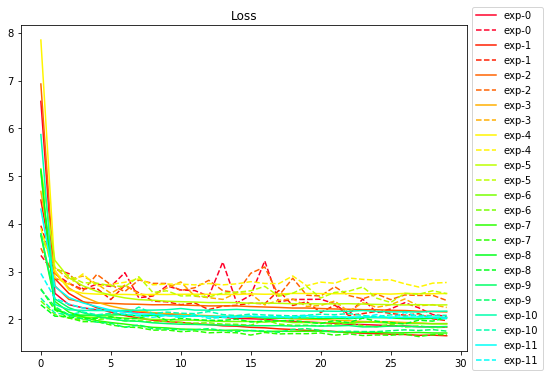

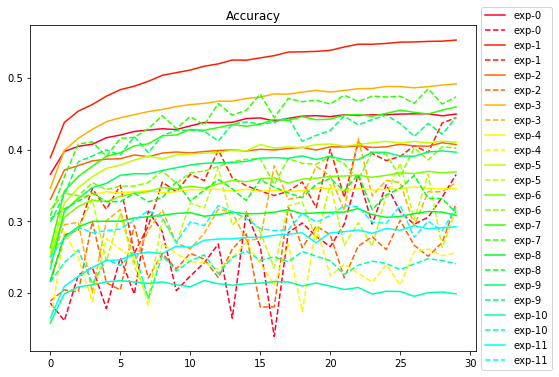

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
"""Code Here
將結果繪出
"""

NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()